# ************************************************************* #
#               Copyright (C) 2022 Jorge Brenes Alfaro.
#               EL5617 Trabajo Final de Graduación.
#               Escuela de Ingeniería Electrónica.
#               Tecnológico de Costa Rica.
# ************************************************************* #

This file is responsible for generating the mimetic neural network (MNN). First, the data collected from the PAHM is processed, which is reshaped as necessary for the network. Next, the model is developed using recurrent neural networks (RNN), specifically the GRU.

In [1]:
#Libraries to proccess data
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Libraries to create RNAM
import tensorflow as tf
from sklearn.preprocessing import MaxAbsScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Dense, Dropout, GRU, TimeDistributed

import warnings
warnings.filterwarnings('ignore')

#import wandb
#from wandb.keras import WandbCallback

#wandb.login()

In [2]:
wandb.init(project="Prueba", 
           entity="mimetic-rna", 
           name='Probando tensorflow cpu5',
           resume='Allow', 
           id='Probando tensorflow cpu5')
wandb.config = {
    "epochs": 10,
    "batch_size": 1,
    "learning_rate":0.001,
    "window": 4,
    "Dropout": 0.35,
    "n_layers":1
}

 Process the Dataset 

In [2]:
def normalizer(angle):
    norm = MaxAbsScaler()
    angle_normalizer = norm.fit_transform(angle)
    return angle_normalizer

In [3]:
# For each element of training set, we have "window" previous training set elements
def window_generator(train, target, window):
    X_train = []
    Y_train = []
    
    for i in range(window,train.shape[0]):
        X_train.append(train[i-window:i])
        Y_train.append(target[i])
        
    X_train, Y_train = np.array(X_train), np.array(Y_train) # Input and output arrays
    Y_train = np.reshape(Y_train,(Y_train.shape[0],1))
    Y_train = normalizer(Y_train)
    return X_train,Y_train

In [4]:
# Separate the values in train, validation and test data/label
def separate_values(X_train, Y_train):
    train_data, val_data, test_data = [],[],[]
    train_label, val_label, test_label = [],[],[]
    train_lenght = int(len(X_train)*3/5)
    val_lenght = int(len(X_train)*4/5)
    
    # Use 3/5 of the total data set for training
    # and 1/5 for validation and testing.
    for i,j in zip(X_train[:train_lenght],Y_train[:train_lenght]):
        train_data.append(i)
        train_label.append(j)
    print(len(train_label))
    
    for i,j in zip(X_train[train_lenght:val_lenght],Y_train[train_lenght:val_lenght]):
        val_data.append(i)
        val_label.append(j)
    
    for i,j in zip(X_train[val_lenght:],Y_train[val_lenght:]):
        test_data.append(i)
        test_label.append(j)
    
    train_data, val_data, test_data = np.array(train_data), np.array(val_data), np.array(test_data)
    train_label, val_label, test_label = np.array(train_label), np.array(val_label), np.array(test_label)
        
    return train_data, train_label, val_data, val_label, test_data, test_label

In [5]:
# Reshape the arrays (n,window,1). Where n is the total amount of data in the array
def GRU_tensor(train_data, train_label, val_data, val_label, test_data, test_label):
    train_data = np.reshape(train_data,(train_data.shape[0],train_data.shape[1],1))
    val_data = np.reshape(val_data,(val_data.shape[0],val_data.shape[1],1))
    test_data = np.reshape(test_data,(test_data.shape[0],test_data.shape[1],1))

    train_label = np.reshape(train_label, (train_label.shape[0]))
    val_label = np.reshape(val_label, (val_label.shape[0]))
    test_label = np.reshape(test_label, (test_label.shape[0]))
    
    return train_data, train_label, val_data, val_label, test_data, test_label

In [7]:
root = '/Users/jorge/Documents/TEC/TFG/Datos_Recolectados/'
Dir = os.listdir(root)
pwm = np.array([])
angle = np.array([])

# Read all the .csv files and make an nx4 array
# Next, separate the pwm value and angle in their respective arrays.
print('******************* Process the Dataset *******************',flush=True)
print('Recolecting Data',flush=True)
for filename in Dir:
    files = pd.read_csv(root+filename)
    pwm = np.append(pwm, np.concatenate((np.zeros(100),files.values[:,2])))
    angle = np.append(angle, np.concatenate((np.zeros(100),files.values[:,3])))

print('Accommodating data for the GRU network',flush=True)
window = 4#wandb.config['window']
train, target = window_generator(pwm,angle,window)

print('Separating data in training, validation and testing',flush=True)
train_data, train_label, val_data, val_label, test_data, test_label = separate_values(train, target)

print('Total train data is: ', len(train_data), flush=True)
print('Total validation data is: ', len(val_data), flush=True)
print('Total testing data is:: ', len(test_data), flush=True)

print('Reshape arrays to tensors',flush=True)
train_X, train_target, val_X, val_target, test_X, test_target = GRU_tensor(train_data, train_label,
                                                                           val_data, val_label,
                                                                           test_data, test_label)
print('\nTrain data shape is: ', train_X.shape, flush=True)
print('Validation data shape is: ', val_X.shape, flush=True)
print('Testing data shape is:: ', test_X.shape, flush=True)
print('Train label shape is: ', train_target.shape, flush=True)
print('Validation label shape is: ', val_target.shape, flush=True)
print('Testing label shape is:: ', test_target.shape, flush=True)

print('******************* Finish *******************',flush=True)

******************* Process the Dataset *******************
Recolecting Data
Accommodating data for the GRU network
Separating data in training, validation and testing
82969
Total train data is:  82969
Total validation data is:  27656
Total testing data is::  27657
Reshape arrays to tensors

Train data shape is:  (82969, 4, 1)
Validation data shape is:  (27656, 4, 1)
Testing data shape is::  (27657, 4, 1)
Train label shape is:  (82969,)
Validation label shape is:  (27656,)
Testing label shape is::  (27657,)
******************* Finish *******************


******************* Neural Network *******************

Model creation

In [19]:
train_X.shape[-1]

1

In [20]:
clear_session()

model = Sequential()
model.add(GRU(units=32, input_shape=(None,train_X.shape[-1]), return_sequences=True))
#model.add(Dropout(wandb.config['Dropout'])
#model.add(Dense(units=1))
model.add(TimeDistributed(Dense(1))) # There is no difference between this and model.add(Dense(1))...
#model.compile(optimizer=Adam(learning_rate=wandb.config['learning_rate']), loss='mean_squared_error', metrics=['mse'])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mse'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 32)          3360      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           33        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


Model Training

In [22]:
history = model.fit(train_X, train_target,
                    epochs=4, batch_size=8,
                    #epochs=wandb.config['epochs'], batch_size=wandb.config['batch_size'],
                    validation_data = (val_X,val_target),
                    verbose=2)#,callbacks=[WandbCallback(save_model=False)])

Epoch 1/4
10372/10372 - 16s - loss: 0.0290 - mse: 0.0290 - val_loss: 0.0116 - val_mse: 0.0116
Epoch 2/4
10372/10372 - 15s - loss: 0.0284 - mse: 0.0284 - val_loss: 0.0113 - val_mse: 0.0113
Epoch 3/4
10372/10372 - 18s - loss: 0.0282 - mse: 0.0282 - val_loss: 0.0112 - val_mse: 0.0112
Epoch 4/4
10372/10372 - 18s - loss: 0.0281 - mse: 0.0281 - val_loss: 0.0113 - val_mse: 0.0113


In [23]:
# Prediction
testPredict = model.predict(test_X)

In [24]:
np.reshape(testPredict,(-1,1))

array([[ 0.20100728],
       [ 0.190794  ],
       [ 0.19349758],
       ...,
       [-0.00455353],
       [-0.00427173],
       [-0.00362994]], dtype=float32)

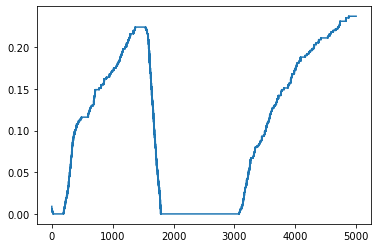

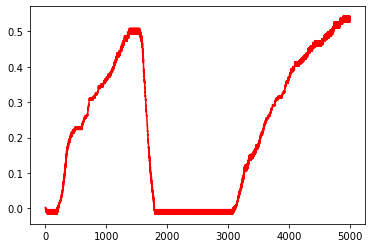

In [26]:
plt.figure()
plt.plot(np.reshape(test_X,-1)[10000:15000],label='Real Ouput')
plt.figure()
plt.plot(np.reshape(testPredict,-1)[10000:15000],'r',label='Predict Output')

Model Evaluate

In [ ]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure()
plt.plot(epochs, loss,'b', label='Training loss')
plt.plot(epochs, val_loss,'r', label='Validation loss')
plt.title('Training and validation losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.savefig('lossLSTM32.png')
plt.show()

In [28]:
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
        
    return np.array(Xs), np.array(ys)

In [30]:
X_train, y_train = create_dataset(train_label,4)

In [33]:
print(X_train.shape)
print(y_train.shape)

(82965, 4, 1)
(82965, 1)


In [36]:
units=32
model = Sequential()
model.add(GRU (units = units, return_sequences = True, input_shape = [X_train.shape[1], X_train.shape[2]]))
model.add(Dropout(0.2)) 
    # Hidden layer
model.add(GRU(units = units))                 
model.add(Dropout(0.2))
model.add(Dense(units = 1)) 
#Compile model
model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_5 (GRU)                  (None, 4, 32)             3360      
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 32)             0         
_________________________________________________________________
gru_6 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = model.fit(X_train, y_train, epochs = 10, validation_split = 0.2,batch_size = 16,verbose=1)

Epoch 1/10
4149/4149 [==============================] - 14s 3ms/step - loss: 6.4541e-04 - val_loss: 4.8816e-04
Epoch 2/10
4149/4149 [==============================] - 13s 3ms/step - loss: 6.2141e-04 - val_loss: 6.0326e-05
Epoch 3/10
4149/4149 [==============================] - 13s 3ms/step - loss: 5.9351e-04 - val_loss: 4.9763e-05
Epoch 4/10
4149/4149 [==============================] - 15s 3ms/step - loss: 5.8664e-04 - val_loss: 4.3102e-05
Epoch 5/10
4149/4149 [==============================] - 13s 3ms/step - loss: 5.7691e-04 - val_loss: 5.7124e-05
Epoch 6/10
4149/4149 [==============================] - 13s 3ms/step - loss: 5.6887e-04 - val_loss: 5.1372e-05
Epoch 7/10
4149/4149 [==============================] - 14s 3ms/step - loss: 5.6310e-04 - val_loss: 9.5796e-05
Epoch 8/10
4149/4149 [==============================] - 15s 4ms/step - loss: 5.5373e-04 - val_loss: 1.1091e-04
Epoch 9/10
4149/4149 [==============================] - 14s 3ms/step - loss: 5.6405e-04 - val_loss: 1.0472e-04
E

In [55]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)
    plt.figure()
    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.figure()
    plt.plot(np.arange(range_future), np.array(prediction), 'r',label='Prediction')
    plt.legend(loc='upper left')
    
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

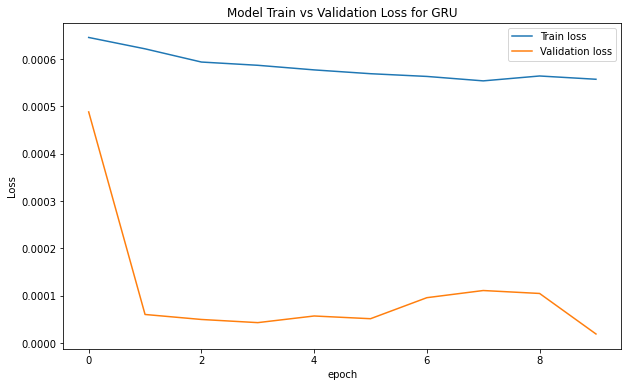

In [43]:
plot_loss(history,'GRU')

In [47]:
testing,test_Y = create_dataset(test_label,4)


In [48]:
testing.shape

(27653, 4, 1)

In [49]:
prediction = model.predict(testing)

<Figure size 720x432 with 0 Axes>

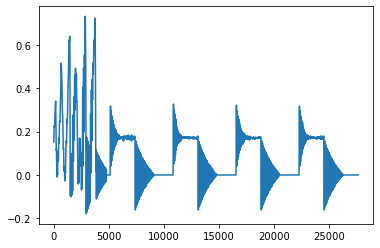

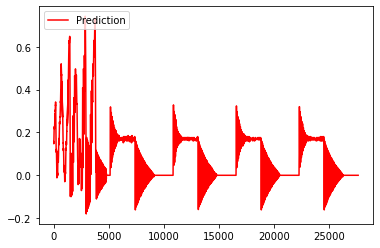

In [56]:
plot_future(prediction,'GRU',test_Y)

In [58]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

In [59]:
evaluate_prediction(prediction,test_Y,'GRU')

GRU:
Mean Absolute Error: 0.0016
Root Mean Square Error: 0.0023

